In [86]:
# -------------------------- Visualization of Raw data

import pandas as pd
import matplotlib.pyplot as plt

# Load OpenBCI data
path1 = "C:/Quick_Disk/tonge_project/data/Recordings_7_classes/data.csv"
path2 = "C:/Quick_Disk/tonge_project/data/Recordings_7_classes2/data1.csv"

# Read both recordings
df1 = pd.read_csv(path1, sep='\t', skiprows=5, engine='python')
df2 = pd.read_csv(path2, sep='\t', skiprows=5, engine='python')

df1.columns = [f"ch_{i}" for i in range(df1.shape[1])]
df2.columns = df1.columns  #

# Combine data vertically (extend in time)
df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

# Define sampling rate and duration
sampling_rate = 250  # Hz
num_samples = df.shape[0]

print(f"Combined data shape: {df.shape}")
print("Combined raw data acquired")




Combined data shape: (314709, 24)
Combined raw data acquired


In [87]:
# -------------------------- Filtering

from scipy.signal import butter, filtfilt
import numpy as np

lowc = 20.0
highc = 120.0

def bandpass_filter(data, lowcut=lowc, highcut=highc, fs=250.0, order=4):
    nyq = 0.5 * fs  # 125 Hz
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def lowpass_filter(data, cutoff=5.0, fs=250.0, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

filtered = {}
for ch in ['ch_1', 'ch_2', 'ch_3','ch_4']:
    # Bandpass
    #raw_filtered = bandpass_filter(df[ch][:num_samples])
    
    # Z-score normalization
    #mean = np.mean(raw_filtered)
    #std = np.std(raw_filtered)
    #zscored = (raw_filtered - mean) / std
    #filtered[ch] = zscored

    #filtered[ch] = raw_filtered
    filtered[ch] = df[ch][:num_samples]
    
print("Signal filtered")


Signal filtered


In [88]:
# -------------------------- Windows from the anotations timestamps

import pandas as pd
import numpy as np

# Load annotations
annotations_path1 = r"C:\Quick_Disk\tonge_project\scripts\data\annotations\7_classes_annotations1.csv"
annotations_path2 = r"C:\Quick_Disk\tonge_project\scripts\data\annotations\7_classes_annotations2.csv"

annotations1 = pd.read_csv(annotations_path1, header=0, names=['class', 'timestamp'])
annotations2 = pd.read_csv(annotations_path2, header=0, names=['class', 'timestamp'])
annotations = pd.concat([annotations1, annotations2], axis=0).reset_index(drop=True)

# Convert timestamp to numeric (float)
annotations['timestamp'] = pd.to_numeric(annotations['timestamp'], errors='coerce')

print("Annotations head")
print(annotations.head())
print("\nEMG head")
print(df.head())

# Get EMG data
emg_timestamps = df['ch_22']  # Unix timestamps 

# Parameters
window_size_seconds = 1
offset = 0.1  # seconds
offsets = [0, -2*offset,-offset, offset, 2*offset]
sampling_rate = 250  # samples per second

# Dictionary for windows
windowed_data = {'l': [], 'k': [], 'r': [], 'e': [], 'f': [], 'n': [], 's': [], 'c': []}

for idx, row in annotations.iterrows():
    label = row['class']
    base_time = row['timestamp']
    
    for shift in offsets:
        start_time = base_time + shift
        end_time = start_time + window_size_seconds

        # Find indices of samples inside this window
        idxs = (df['ch_22'] >= start_time) & (df['ch_22'] < end_time)

        if not any(idxs):
            print(f"No data for window starting at {start_time:.3f} (label={label}, offset={shift:+.1f}s)")
            continue

        # Extract samples for each channel in this window
        #window_ch1 = filtered['ch_1'][idxs]
        #window_ch2 = filtered['ch_2'][idxs]
        #window_ch3 = filtered['ch_3'][idxs]
        #window_ch4 = filtered['ch_4'][idxs]

        # Extract and z-score normalize each channel
        window_data = {}
        for ch in ['ch_1', 'ch_2', 'ch_3', 'ch_4']:
            # bandpass
            #raw_signal = filtered[ch][idxs]
            raw_signal = bandpass_filter(filtered[ch][idxs])
            if len(raw_signal) == 0:
                continue
                
            # zscore normalization
            #mean = np.mean(raw_signal)
            #std = np.std(raw_signal)
            #zscored_signal = (raw_signal - mean) / std if std != 0 else raw_signal  # Avoid divide-by-zero
            #window_data[ch] = zscored_signal

            window_data[ch] = raw_signal

        # Store window
        windowed_data[label].append({
            'ch_1': window_data.get('ch_1', []),
            'ch_2': window_data.get('ch_2', []),
            'ch_3': window_data.get('ch_3', []),
            'ch_4': window_data.get('ch_4', []),
            'start_time': start_time,
            'end_time': end_time,
            'offset': shift
        })

# Check how many windows per class
print("\nHow many windows per class:")
for c in ['l', 'k', 'r', 'e', 'f', 'n', 's', 'c']:
    print(f"Class '{c}' windows: {len(windowed_data[c])}")

# Double check: how many samples in the first window, should be 250
first_window_l = windowed_data['l'][0]
print("\nNumber of samples in first 'l' window:")
print("ch_1:", len(first_window_l['ch_1']))
print("ch_2:", len(first_window_l['ch_2']))
print("ch_3:", len(first_window_l['ch_3']))
print("ch_4:", len(first_window_l['ch_4']))

# Double check: print first window
#first_l_window = windowed_data['l'][0]
#fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
#for i, ch in enumerate(['ch_1', 'ch_2', 'ch_3', 'ch_4']):
#    axs[i].plot(first_l_window[ch])
#    axs[i].set_title(f"{ch} - first 'left' window")
#    axs[i].grid(True)
#    axs[i].set_ylabel("Amplitude")
#axs[-1].set_xlabel("Sample Index")
#plt.tight_layout()
#plt.show()


Annotations head
  class     timestamp
0     n  1.749545e+09
1     n  1.749545e+09
2     n  1.749545e+09
3     n  1.749545e+09
4     n  1.749545e+09

EMG head
   ch_0          ch_1          ch_2         ch_3        ch_4  ch_5  ch_6  \
0   6.0  12087.801050 -12618.610277  1985.661922 -658.527095   0.0   0.0   
1   7.0  11425.027123 -12625.315800  1989.953457 -662.304540   0.0   0.0   
2   8.0  11839.227300 -12624.466434  1986.958323 -660.315235   0.0   0.0   
3   9.0  12776.815924 -12613.178803  1978.151736 -654.190857   0.0   0.0   
4  10.0  12963.564749 -12616.039826  1971.781489 -652.492124   0.0   0.0   

   ch_7  ch_8   ch_9  ...  ch_14  ch_15  ch_16  ch_17  ch_18  ch_19  ch_20  \
0   0.0   0.0 -0.072  ...  192.0  252.0  240.0   23.0   80.0    0.0    0.0   
1   0.0   0.0 -0.072  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2   0.0   0.0 -0.072  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3   0.0   0.0 -0.072  ...    0.0    0.0    0.0    0.0    0.0    0.0    0

In [96]:
# -------------------------- Feature extraction

import numpy as np
import pandas as pd

#--------------Feature functions
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def zero_crossings(signal):
    signs = np.sign(signal)
    # Replace zeros with the previous sign or 1 (to avoid false zero crossings)
    for i in range(1, len(signs)):
        if signs[i] == 0:
            signs[i] = signs[i-1] if signs[i-1] != 0 else 1
    return np.sum(np.diff(signs) != 0)


def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal)))

def mav(signal): # mean absolute value
    return np.mean(np.abs(signal))

def iav(signal):  # Integrated Absolute Value
    return np.sum(np.abs(signal))

# Not used:
def ssc(signal, threshold=1e-3): # slope sign changes
    diff = np.diff(signal)
    return np.sum(((diff[1:] * diff[:-1]) < 0) & 
                  (np.abs(diff[1:] - diff[:-1]) > threshold))

def wamp(signal, threshold=1.2): # Number of times difference between samples > threshold
    return np.sum(np.abs(np.diff(signal)) > threshold)

def iemg(signal): # Integrated EMG (IEMG)	
    return np.sum(np.abs(signal))

# ----------------------------------

# Prepare lists to collect features and labels
features = []
labels = []

# Loop over all classes and windows
for label in ['l', 'k', 'r', 'e', 'f', 'n', 's', 'c']:
    for window in windowed_data[label]:
        # Extract channel signals
        ch1 = window['ch_1']
        ch2 = window['ch_2']
        ch3 = window['ch_3']
        ch4 = window['ch_4']
        
        # Compute features per channel
        feats = []
        for ch_signal in [ch1, ch2, ch3, ch4]:
            feats.append(rms(ch_signal))
            feats.append(zero_crossings(ch_signal)) 
            feats.append(waveform_length(ch_signal)) 
            
            # added features
            feats.append(mav(ch_signal)) # mean absolute value
            feats.append(np.std(ch_signal))       # Standard deviation
            feats.append(np.var(ch_signal))       # Variance
            feats.append(iav(ch_signal))          # Integrated Absolute Value
        
        features.append(feats)
        labels.append(label)

# Create column names
feature_names = ['RMS', 'ZC', 'WL', 'MAV', 'STD', 'VAR', 'IAV']

cols = []
for ch in ['ch_1', 'ch_2', 'ch_3', 'ch_4']:
    for feat_name in feature_names:
        cols.append(f"{ch}_{feat_name}")


# Create DataFrame
X = pd.DataFrame(features, columns=cols)
y = pd.Series(labels, name='label')

print(X.head())
print(y.head())


    ch_1_RMS  ch_1_ZC      ch_1_WL   ch_1_MAV   ch_1_STD    ch_1_VAR  \
0  21.665421      105  5382.431352  17.350801  21.665292  469.384893   
1  22.662203      106  5490.244880  18.163246  22.660886  513.515744   
2  21.544750      104  5307.647101  17.373120  21.544200  464.152542   
3  21.261800      100  5258.613174  16.882096  21.260282  451.999580   
4  21.665730      101  5379.697982  17.274070  21.665663  469.400963   

      ch_1_IAV   ch_2_RMS  ch_2_ZC      ch_2_WL  ...   ch_3_STD     ch_3_VAR  \
0  4337.700182  17.621567      110  4454.643069  ...  49.236065  2424.190096   
1  4540.811509  18.126273      109  4544.437402  ...  49.202780  2420.913589   
2  4343.280069  17.788048      112  4545.964183  ...  49.827692  2482.798882   
3  4220.523897  17.901359      107  4498.679005  ...  49.796700  2479.711316   
4  4318.517437  17.222433      109  4371.113418  ...  49.165603  2417.256480   

       ch_3_IAV  ch_4_RMS  ch_4_ZC      ch_4_WL  ch_4_MAV  ch_4_STD  \
0  10484.085549

Random Forest Test Accuracy: 0.913


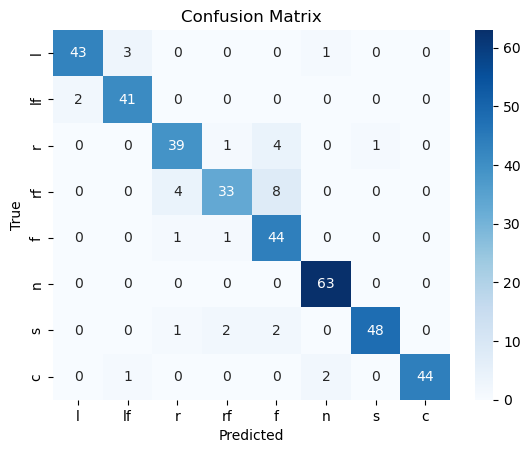

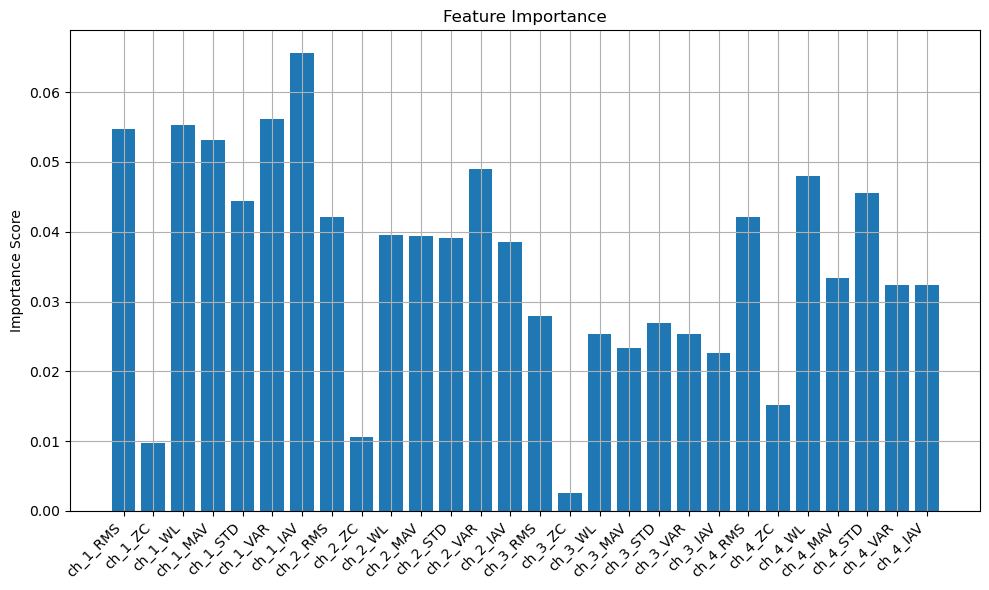

['scaler_rf2.pkl']

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Scale features (even if not strictly needed for RF)
scaler = StandardScaler()
X_train_scaled_array = scaler.fit_transform(X_train)
X_test_scaled_array = scaler.transform(X_test)

# Wrap back into DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X.columns)

# 3. Train 
clf_RF = RandomForestClassifier(n_estimators=100, random_state=42)
clf_RF.fit(X_train_scaled, y_train)

# 4. Predict
y_pred = clf_RF.predict(X_test_scaled)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'k', 'r', 'e', 'f', 'n', 's', 'c'])

print(f"Random Forest Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'r', 'rf', 'f', 'n', 's', 'c'],
            yticklabels=['l', 'lf', 'r', 'rf', 'f', 'n', 's', 'c'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Plot feature importance
importances = clf_RF.feature_importances_
feature_names = X.columns if hasattr(X, 'columns') else [f'feat{i}' for i in range(X.shape[1])]

plt.figure(figsize=(10,6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Save model and scaler
joblib.dump(clf_RF, "7_classes_rf2.pkl")
joblib.dump(scaler, "scaler_rf2.pkl")
